In [1]:
#comparacion por regiones

In [2]:
import psycopg2
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib notebook

def promedio(espectro, nfft):
    """ Realiza promedios del espectro,
    debido a que las muestras estan almacenadas en un vector de tamano N
    que se subdivide N/nfft veces y ese es el numero que se promedia (K)"""
    K = int(len(espectro)/(nfft))
    x = numpy.zeros(nfft)
    for i in range(K):
        x = x + espectro[i*nfft:(i+1)*nfft]
    x = x/K
    return x   

In [3]:
conn = psycopg2.connect(database="centrotic", user="postgres",
                      password="raspberry", host="127.0.0.1",
                      port="5432")
cur = conn.cursor()

# seleccion de regiones

In [4]:
query_region = []
query_region.append("SELECT id, zona FROM radioastronomia_regioncampana;")
query_region = "".join(query_region)

In [5]:
print(query_region)

SELECT id, zona FROM radioastronomia_regioncampana;


In [6]:
cur.execute(query_region)
rows = cur.fetchall()

ids = [rows[0][0]]
print(ids)
print(rows)

[8]
[(8, 'UIS')]


# Seleccion de frecuencia central

In [7]:
query_freq = []
query_freq.append("SELECT DISTINCT frec_central FROM radioastronomia_espectro ORDER BY frec_central;")
query_freq = "".join(query_freq)
print(query_freq)

SELECT DISTINCT frec_central FROM radioastronomia_espectro ORDER BY frec_central;


In [8]:
cur.execute(query_freq)
frec_central = cur.fetchall()

In [9]:
for i in ids:
    y = numpy.array([])
    freq = numpy.array([])
    for frec_cen in frec_central:
        query_espectro = "SELECT espectro FROM radioastronomia_espectro WHERE frec_central = %s AND region_id = %s"
        cur.execute(query_espectro, [frec_cen[0], i])
        rows = cur.fetchall()
        
        x_ = numpy.zeros(1024)
        for row in rows:
            espectro = row[0]
            espectro = numpy.asarray(espectro)
            x = promedio(espectro, 1024)
            x_ = x_ + x
        x_ = x_/len(rows)
        freq = numpy.append(freq, numpy.arange(-int(1024/2),int(1024/2),1)*4000000/(1024*2) + frec_cen[0])
        y = numpy.append(y,x_)

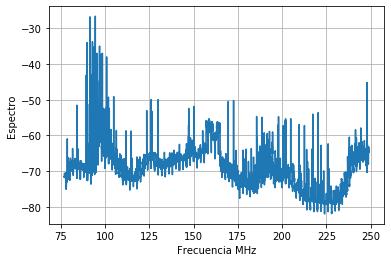

In [10]:
plt.plot(freq/1e6, y)
plt.xlabel("Frecuencia MHz")
plt.ylabel("Espectro")
plt.grid(True)

# Caracteristicas para comparacion de zonas

In [11]:
df = pd.DataFrame(data=y, index=freq, columns=["Espectro"])
print(df.head())
print(df.info())
print(df.describe())

               Espectro
7.700000e+07 -71.669738
7.700195e+07 -71.703173
7.700391e+07 -71.777141
7.700586e+07 -71.811265
7.700781e+07 -71.756214
<class 'pandas.core.frame.DataFrame'>
Float64Index: 88064 entries, 77000000.0 to 248998046.875
Data columns (total 1 columns):
Espectro    88064 non-null float64
dtypes: float64(1)
memory usage: 1.3 MB
None
           Espectro
count  88064.000000
mean     -69.434668
std        5.464933
min      -82.023691
25%      -72.615839
50%      -69.225961
75%      -66.179902
max      -26.610850


In [12]:
#caracteristicas 
energia = 10*numpy.log10(numpy.sum(10**(y/10)))
media = numpy.mean(y)
mediana = numpy.median(y)
std = numpy.std(y)
max_ = numpy.max(y)
min_ = numpy.min(y)

In [13]:
ener = [energia, energia+10, energia+numpy.random.random()]
media_ = [media, media+1, media+2]
mediana_ = [mediana, mediana+1, mediana+2]
std_ = [std, std+1, std+2]
max__ = [max_, max_+1, max_+2]
min__ = [min_, min_+1, min_+2]

columns = ["ener", "media", "mediana", "std", "max", "min"] 
X = numpy.vstack([ener, media_, mediana_, std_, max__, min__])

df = pd.DataFrame(data=X.T, columns=columns)
target =[1,1,3]
print(df.head())

        ener      media    mediana       std       max        min
0 -10.584241 -69.434668 -69.225961  5.464902 -26.61085 -82.023691
1  -0.584241 -68.434668 -68.225961  6.464902 -25.61085 -81.023691
2 -10.448944 -67.434668 -67.225961  7.464902 -24.61085 -80.023691


In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)

In [16]:
#PCA
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
print(x_pca)

[[ 2.74331068 -0.70343129]
 [-0.00932434  1.41408443]
 [-2.73398635 -0.71065314]]


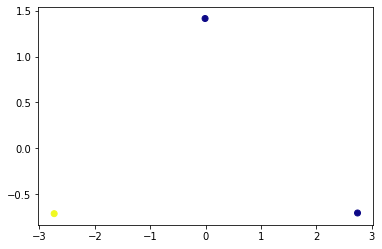

In [18]:
plt.scatter(x_pca[:,0], x_pca[:,1], c=target, cmap="plasma")

In [19]:
conn.close()